In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import shapiro
from scipy.optimize import brentq
from scipy.integrate import quad
from scipy.optimize import minimize
from numpy.polynomial.laguerre import laggauss

from dateutil import parser
from dateutil.tz import tzutc

sns.set_style('darkgrid')

In [ ]:
## Randomly generated stock paths as Geometric Brownian Motions

def GBM_paths(S0, sigma, t, r, mu, n_sims, n_steps):
    """Simulates stock paths as geometric Brownian Motions
    Inputs:
    S0 (float): Underlying stock price at time 0
    sigma (float): Yearly volatility
    t (float): Time to expiration (years)
    r (float): Risk-free interest rate
    mu (float): Drift of log-returns
    n_sims (int): Number of simulated paths
    n_steps (int): Number of steps in each simulated path, each step interval has length t/n_steps

    Return (np.array): Array of stock paths
    """

    dt = t/n_steps
    noise = np.random.normal(loc = 0, scale = 1, size = (n_sims, n_steps))
    log_returns = (mu+r-sigma**2*(0.5))*dt + sigma*np.sqrt(dt)*noise
    exponent = np.cumsum(log_returns, axis = 1)
    paths = S0*np.exp(exponent)
    paths_with_start = np.insert(paths, 0, S0, axis = 1)

    return paths_with_start


In [ ]:
##Black-Scholes Functions
def bs_call(S0, K, sigma, t, r):
    '''
    Black-Scholes Call Option formula

    Inputs:
    S0 (float): Stock price at time 0
    K (float): Strike Price
    sigma: Yearly volatility
    t: Time to expiration (years)
    r: Risk-free Interest rate


    Return:
    Black-Scholes value of call option (float)
    '''

    d1 = (np.log(S0/K) + (r + (0.5)*sigma**2)*t)/(sigma*np.sqrt(t))

    d2 = d1 - sigma*np.sqrt(t)


    call_value = S0*norm.cdf(d1) - K*np.exp(-r*t)*norm.cdf(d2)


    return call_value



def bs_put(S0, K, sigma, t, r):
    '''
    Black-Scholes Put Option formula

    Inputs:
    S0 (float): Stock price at time 0
    K (float): Strike Price
    sigma: Yearly volatility
    t: Time to expiration (years)
    r: Risk-free Interest rate


    Return:
    Black-Scholes value of put option (float)
    '''

    d1 = (np.log(S0/K) + (r + (0.5)*sigma**2)*t)/(sigma*np.sqrt(t))

    d2 = d1 - sigma*np.sqrt(t)


    put_value = -S0*norm.cdf(-d1) + K*np.exp(-r*t)*norm.cdf(-d2)


    return put_value


def bs_call_delta(S0, K, sigma, t, r):
    '''Black-Scholes Delta of Call Option

    Inputs:
    S0 (float): Stock price at time 0
    K (float): Strike Price
    sigma: Yearly volatility
    t: Time to expiration (years)
    r: Risk-free Interest rate


    Return:
    Black-Scholes rate of change of call option with respect to S_0

    '''


    d1 = (np.log(S0/K) + (r + (0.5)*sigma**2)*t)/(sigma*np.sqrt(t))


    return norm.cdf(d1)



def bs_put_delta(S0, K, sigma, t, r):
    '''Black-Scholes Delta of Put Option

    Inputs:
    S0 (float): Stock price at time 0
    K (float): Strike Price
    sigma: Yearly volatility
    t: Time to expiration (years)
    r: Risk-free Interest rate


    Return:
    Black-Scholes rate of change of put option with respect to S_0

    '''
    d1 = (np.log(S0/K) + (r + (0.5)*sigma**2)*t)/(sigma*np.sqrt(t))


    return -1 + norm.cdf(d1)


def bs_vega(S0, K, sigma, t, r):
    '''Black-Scholes vega of Call & Put Options

    Inputs:
    S0 (float): Stock price at time 0
    K (float): Strike Price
    sigma: Yearly volatility
    t: Time to expiration (years)
    r: Risk-free Interest rate


    Return:
    Black-Scholes rate of change of call & put option with respect to sigma

    '''

    d1 = (np.log(S0/K) + (r + (0.5)*sigma**2)*t)/(sigma*np.sqrt(t))


    return S0*norm.pdf(d1)*np.sqrt(t)




[*********************100%***********************]  8 of 8 completed


Running AAPL...
Running AMZN...
Running GOOGL...
Running META...
Running MSFT...
Running NVDA...
Running TSLA...
Running SPY...
             mean       std  count    Sharpe
Ticker                                      
AAPL     4.320768  1.185836     24  3.643646
AMZN     3.628018  1.457003     24  2.490054
GOOGL    3.287283  1.209277     24  2.718387
META     8.386824  4.616465     24  1.816720
MSFT     8.564954  3.092053     24  2.769989
NVDA     1.525247  1.156713     24  1.318605
SPY     12.119916  3.445987     24  3.517110
TSLA     6.009892  4.456451     24  1.348583


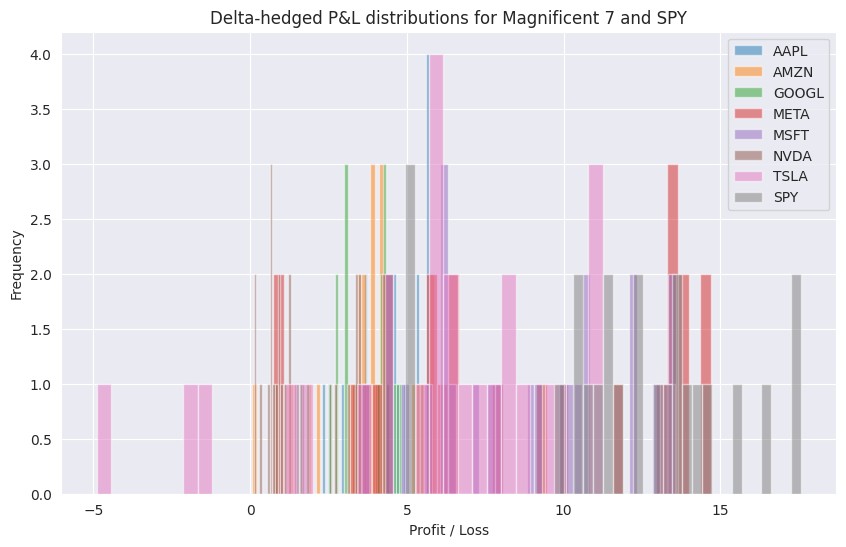

In [ ]:
# --- Parameters ---
tickers = ["AAPL", "AMZN", "GOOGL", "META", "MSFT", "NVDA", "TSLA", "SPY"]
r = 0.035
window = 252

data = yf.download(tickers, start="2022-01-01", end="2025-01-01", auto_adjust=True)
data_close = data["Close"]  # already adjusted
returns = np.log(data_close / data_close.shift(1))
realized_vol = returns.rolling(window).std() * np.sqrt(252)

# --- Hedging function ---
def hedge_on_historical_path(prices, K, sigma_real, sigma_model, r):
    n_steps = len(prices) - 1
    T = 1
    times = np.linspace(0, T, n_steps + 1)
    S = prices.values
    deltas = np.zeros(n_steps + 1)
    for j in range(n_steps + 1):
        tau = T - times[j]
        if tau == 0:
            tau = 1e-8
        deltas[j] = bs_call_delta(S[j], K, sigma_model, tau, r)
    stock_changes = S[1:] - S[:-1]
    stock_profits = deltas[:-1] * stock_changes
    discount_factors = np.exp(-r * times[1:])
    total_stock_profits = np.sum(stock_profits * discount_factors)
    call_payout_discounted = max(S[-1] - K, 0) * np.exp(-r * T)
    premium = bs_call(S[0], K, sigma_model, T, r)
    pnl = premium + total_stock_profits - call_payout_discounted
    return pnl

results = []
for ticker in tickers:
    print(f"Running {ticker}...")
    series = data_close[ticker].dropna()
    realized_vol_series = realized_vol[ticker]
    for i in range(252, len(series) - 1, 21):
        sigma_real = realized_vol_series.iloc[i]
        if np.isnan(sigma_real) or sigma_real <= 0:
            continue
        window_prices = series.iloc[i - 252 : i + 1]
        sigma_model = sigma_real + 0.01 #can change the 0.01, this just says how much more the price of the option is in the market
        K = window_prices.iloc[0]
        pnl = hedge_on_historical_path(window_prices, K, sigma_real, sigma_model, r)
        results.append({
            "Ticker": ticker,
            "StartDate": window_prices.index[0],
            "EndDate": window_prices.index[-1],
            "SigmaReal": sigma_real,
            "SigmaModel": sigma_model,
            "PnL": pnl
        })

df_results = pd.DataFrame(results)
summary = df_results.groupby("Ticker")["PnL"].agg(["mean", "std", "count"])
summary["Sharpe"] = summary["mean"] / summary["std"]
print(summary)

plt.figure(figsize=(10,6))
for ticker in tickers:
    subset = df_results[df_results["Ticker"] == ticker]
    plt.hist(subset["PnL"], bins=40, alpha=0.5, label=ticker)
plt.legend()
plt.title("Delta-hedged P&L distributions for Magnificent 7 and SPY")
plt.xlabel("Profit / Loss")
plt.ylabel("Frequency")
plt.show()

In [ ]:
##Implied volatility functions
def implied_volatility_call(market_price, S0, K, t, r, sigma_bounds=(1e-6, 2)):
    def objective(sigma):
        return bs_call(S0, K, sigma, t, r) - market_price

    try:
        return brentq(objective, *sigma_bounds)
    except ValueError:
        return np.nan

def implied_volatility_put(market_price, S0, K, t, r, sigma_bounds=(1e-6, 2)):
    def objective(sigma):
        return bs_put(S0, K, sigma, t, r) - market_price

    try:
        return brentq(objective, *sigma_bounds)
    except ValueError:
        return np.nan



##Functions for option data obtained through y-finance
def find_tte_yf_options(expiration_date,last_trade_date):
    tte = (datetime.datetime.strptime(expiration_date+'-21-30', "%Y-%m-%d-%H-%M").replace(tzinfo=tzutc()) -\
last_trade_date).total_seconds()/(60*60*24*365)

    return tte


def yf_find_approx_spot(stock_data, last_trade_date):
    # Round timestamp to the minute (zero out seconds)
    ts = last_trade_date.replace(second=0)

    try:
        return stock_data.loc[ts].iloc[0]
    except KeyError:
        return float('nan')

In [ ]:
## Heston functions using the characteristic function of the Heston model derived by Heston.

def heston_call(S0, K, v0, r, t, kappa, theta, xi, rho):

    def integrand(phi, Pnum):
        i = complex(0, 1)
        u = 0.5 if Pnum == 1 else -0.5
        b = kappa - rho * xi if Pnum == 1 else kappa
        a = kappa * theta
        d = np.sqrt((rho * xi * phi * i - b)**2 - xi**2 * (2 * u * phi * i - phi**2))
        g = (b - rho * xi * phi * i + d) / (b - rho * xi * phi * i - d)

        exp1 = np.exp(i * phi * np.log(S0 / K))
        C = r * phi * i * t + a / xi**2 * ((b - rho * xi * phi * i + d) * t - 2 * np.log((1 - g * np.exp(d * t)) / (1 - g)))
        D = (b - rho * xi * phi * i + d) / xi**2 * ((1 - np.exp(d * t)) / (1 - g * np.exp(d * t)))
        f = exp1 * np.exp(C + D * v0)
        return np.real(f / (phi * i))

    P1 = 0.5 + (1 / np.pi) * quad(lambda phi: integrand(phi, 1), 0, 100)[0]
    P2 = 0.5 + (1 / np.pi) * quad(lambda phi: integrand(phi, 2), 0, 100)[0]
    call_price = S0 * P1 - K * np.exp(-r * t) * P2
    return call_price


def heston_call_delta(S0, K, v0, r, t, kappa, theta, xi, rho):
    def integrand(phi, Pnum):
        i = complex(0, 1)
        u = 0.5 if Pnum == 1 else -0.5
        b = kappa - rho * xi if Pnum == 1 else kappa
        a = kappa * theta
        d = np.sqrt((rho * xi * phi * i - b)**2 - xi**2 * (2 * u * phi * i - phi**2))
        g = (b - rho * xi * phi * i + d) / (b - rho * xi * phi * i - d)

        exp1 = np.exp(i * phi * np.log(S0 / K))
        C = r * phi * i * t + a / xi**2 * ((b - rho * xi * phi * i + d) * t - 2 * np.log((1 - g * np.exp(d * t)) / (1 - g)))
        D = (b - rho * xi * phi * i + d) / xi**2 * ((1 - np.exp(d * t)) / (1 - g * np.exp(d * t)))
        f = exp1 * np.exp(C + D * v0)
        return np.real(f / (phi * i))

    P1 = 0.5 + (1 / np.pi) * quad(lambda phi: integrand(phi, 1), 0, 100)[0]
    return P1

def heston_put(S0, K, v0, r, t, kappa, theta, xi, rho):
    def integrand(phi, Pnum):
        i = complex(0, 1)
        u = 0.5 if Pnum == 1 else -0.5
        b = kappa - rho * xi if Pnum == 1 else kappa
        a = kappa * theta
        d = np.sqrt((rho * xi * phi * i - b)**2 - xi**2 * (2 * u * phi * i - phi**2))
        g = (b - rho * xi * phi * i + d) / (b - rho * xi * phi * i - d)

        exp1 = np.exp(i * phi * np.log(S0 / K))
        C = r * phi * i * t + a / xi**2 * ((b - rho * xi * phi * i + d) * t - 2 * np.log((1 - g * np.exp(d * t)) / (1 - g)))
        D = (b - rho * xi * phi * i + d) / xi**2 * ((1 - np.exp(d * t)) / (1 - g * np.exp(d * t)))
        f = exp1 * np.exp(C + D * v0)
        return np.real(f / (phi * i))

    P1 = 0.5 + (1 / np.pi) * quad(lambda phi: integrand(phi, 1), 0, 100)[0]
    P2 = 0.5 + (1 / np.pi) * quad(lambda phi: integrand(phi, 2), 0, 100)[0]

    call_price = S0 * P1 - K * np.exp(-r * t) * P2
    put_price = call_price - S0 + K * np.exp(-r * t)  # via put-call parity

    return put_price


def heston_put_delta(S0, K, v0, r, t, kappa, theta, xi, rho):
    def integrand(phi, Pnum):
        i = complex(0, 1)
        u = 0.5 if Pnum == 1 else -0.5
        b = kappa - rho * xi if Pnum == 1 else kappa
        a = kappa * theta
        d = np.sqrt((rho * xi * phi * i - b)**2 - xi**2 * (2 * u * phi * i - phi**2))
        g = (b - rho * xi * phi * i + d) / (b - rho * xi * phi * i - d)

        exp1 = np.exp(i * phi * np.log(S0 / K))
        C = r * phi * i * t + a / xi**2 * ((b - rho * xi * phi * i + d) * t - 2 * np.log((1 - g * np.exp(d * t)) / (1 - g)))
        D = (b - rho * xi * phi * i + d) / xi**2 * ((1 - np.exp(d * t)) / (1 - g * np.exp(d * t)))
        f = exp1 * np.exp(C + D * v0)
        return np.real(f / (phi * i))

    P2 = 0.5 + (1 / np.pi) * quad(lambda phi: integrand(phi, 2), 0, 100)[0]
    return P2



def heston_option(S0, K, v0, r, t, kappa, theta, xi, rho, option_type):
    def integrand(phi, Pnum):
        i = complex(0, 1)
        u = 0.5 if Pnum == 1 else -0.5
        b = kappa - rho * xi if Pnum == 1 else kappa
        a = kappa * theta
        d = np.sqrt((rho * xi * phi * i - b)**2 - xi**2 * (2 * u * phi * i - phi**2))
        g = (b - rho * xi * phi * i + d) / (b - rho * xi * phi * i - d)

        exp1 = np.exp(i * phi * np.log(S0 / K))
        C = r * phi * i * t + a / xi**2 * ((b - rho * xi * phi * i + d) * t - 2 * np.log((1 - g * np.exp(d * t)) / (1 - g)))
        D = (b - rho * xi * phi * i + d) / xi**2 * ((1 - np.exp(d * t)) / (1 - g * np.exp(d * t)))
        f = exp1 * np.exp(C + D * v0)
        return np.real(f / (phi * i))

    P1 = 0.5 + (1 / np.pi) * quad(lambda phi: integrand(phi, 1), 0, 100)[0]
    P2 = 0.5 + (1 / np.pi) * quad(lambda phi: integrand(phi, 2), 0, 100)[0]
    call_price = S0 * P1 - K * np.exp(-r * t) * P2
    put_price = call_price - S0 + K * np.exp(-r * t)

    if option_type == 'call':
        return call_price

    if option_type == 'put':
        return put_price


def heston_paths(S0, v0, r, t, rho, kappa, theta, xi, mu, n_sims, n_steps):

    dt = t/n_steps


    times = np.linspace(0,t, n_steps + 1)


    #noise in random processes with correlation rho

    noise1 = np.random.normal(size = (n_sims,n_steps))

    Y = np.random.normal(size = (n_sims,n_steps))

    noise2 = rho*noise1 + np.sqrt(1-rho**2)*Y #noise1 and noise2 both standard normal, but have correlation rho


    vols = np.zeros((n_sims,n_steps))

    vols[:,0] = v0

    for i in range(1, n_steps):
        vols[:,i] = vols[:,i-1] + kappa*(theta - vols[:,i-1])*dt + xi*np.sqrt(vols[:,i-1]*dt)*noise1[:,i-1]
        vols[:,i] = np.maximum(vols[:,i], 0)

    log_returns = (mu + r - vols/2)*dt + np.sqrt(vols*dt)*noise2

    exponent = np.cumsum(log_returns, axis = 1)

    paths = S0*np.exp(exponent)

    paths = np.insert(paths, 0, S0, axis = 1)

    return paths

In [ ]:
def heston_hedge_path(prices, K, v0, r, T, kappa, theta, xi, rho, transaction_cost=0.0):

    n_steps = len(prices) - 1
    dt = T / n_steps
    S = prices.values

    try:
        initial_option_price = heston_call(S[0], K, v0, r, T, kappa, theta, xi, rho)
        initial_delta = heston_call_delta(S[0], K, v0, r, T, kappa, theta, xi, rho)
    except:
        return np.nan

    cash = initial_option_price
    shares = initial_delta
    cash -= shares * S[0]

    for i in range(1, n_steps + 1):
        tau = max(T - i * dt, 1e-8)
        cash *= np.exp(r * dt)

        try:
            new_delta = heston_call_delta(S[i], K, v0, r, tau, kappa, theta, xi, rho)
        except:
            return np.nan

        delta_change = new_delta - shares
        trade_cost = abs(delta_change) * S[i] * transaction_cost
        cash -= delta_change * S[i] + trade_cost
        shares = new_delta
    payoff = max(S[-1] - K, 0)
    final_portfolio_value = cash + shares * S[-1]
    pnl = final_portfolio_value - payoff

    return pnl

def bs_hedge_path(prices, K, sigma_model, r, T, transaction_cost=0.0):
    n_steps = len(prices) - 1
    dt = T / n_steps
    S = prices.values

    cash = bs_call(S[0], K, sigma_model, T, r)
    shares = bs_call_delta(S[0], K, sigma_model, T, r)
    cash -= shares * S[0]

    for i in range(1, n_steps + 1):
        tau = max(T - i * dt, 1e-8)
        cash *= np.exp(r * dt)

        new_delta = bs_call_delta(S[i], K, sigma_model, tau, r)
        delta_change = new_delta - shares
        trade_cost = abs(delta_change) * S[i] * transaction_cost
        cash -= delta_change * S[i] + trade_cost
        shares = new_delta

    payoff = max(S[-1] - K, 0)
    pnl = cash + shares * S[-1] - payoff

    return pnl

results_heston = []
results_bs = []

for ticker in tickers:
    print(f"Running {ticker}...")
    series = data_close[ticker].dropna()
    realized_vol_series = realized_vol[ticker]

    for i in range(252, len(series) - 1, 21):
        sigma_real = realized_vol_series.iloc[i]
        if np.isnan(sigma_real) or sigma_real <= 0:
            continue

        window_prices = series.iloc[i - 252 : i + 1]
        v0 = sigma_real ** 2
        K = window_prices.iloc[0]
        T = 1.0

        pnl_heston = heston_hedge_path(window_prices, K, v0, r, T,
                                       kappa, theta, xi, rho, transaction_cost)

        sigma_model = sigma_real + 0.01 #
        pnl_bs = bs_hedge_path(window_prices, K, sigma_model, r, T, transaction_cost)

        if not np.isnan(pnl_heston):
            results_heston.append({
                "Ticker": ticker,
                "PnL": pnl_heston,
                "Model": "Heston"
            })

        if not np.isnan(pnl_bs):
            results_bs.append({
                "Ticker": ticker,
                "PnL": pnl_bs,
                "Model": "Black-Scholes"
            })

df_heston = pd.DataFrame(results_heston)
df_bs = pd.DataFrame(results_bs)

print("\n=== Heston Results ===")
print(df_heston.groupby("Ticker")["PnL"].agg(["mean", "std", "count"]))

print("\n=== Black-Scholes Results ===")
print(df_bs.groupby("Ticker")["PnL"].agg(["mean", "std", "count"]))

Running AAPL...
Running AMZN...
Running GOOGL...
Running META...
Running MSFT...
Running NVDA...
Running TSLA...
Running SPY...

=== Heston Results ===
            mean        std  count
Ticker                            
AAPL   -2.007821   2.834593    108
AMZN   -2.947253   3.545619    108
GOOGL  -1.947878   2.423367    108
META   -7.121041   7.021823    108
MSFT   -3.232284   5.523843    108
NVDA   -0.511493   0.644009    108
SPY    -0.800542   6.597836    108
TSLA   -7.713993  10.001996    108

=== Black-Scholes Results ===
            mean       std  count
Ticker                           
AAPL    0.053983  0.780324    108
AMZN    0.274976  1.264629    108
GOOGL  -0.048368  0.754134    108
META    0.202173  2.841396    108
MSFT   -0.174054  1.150549    108
NVDA    0.012082  0.218811    108
SPY     0.378486  2.146888    108
TSLA    0.497429  2.651818    108


In [33]:
def heston_hedge_historical(stock_data, tickers, r, kappa, theta, xi, rho,
                            t=1, n_steps=252):
    results = []
    dt = t / n_steps

    for ticker in tickers:
        print(f"Hedging {ticker}...")

        stock_path = np.array(stock_data['Close'][ticker].values[-n_steps-1:])

        returns = np.log(stock_data['Close'][ticker].pct_change() + 1)
        rolling_vol = returns.rolling(window=21).std() * np.sqrt(252)
        rolling_variance = (rolling_vol ** 2).iloc[-n_steps-1:].fillna(method='bfill')

        S0 = stock_path[0]
        K = S0
        v0 = rolling_variance.iloc[0]

        if np.isnan(v0) or v0 <= 0:
            print(f"  Skipping {ticker} - invalid initial variance")
            continue
        try:
            initial_premium = heston_call(S0, K, v0, r, t, kappa, theta, xi, rho)
            initial_delta = heston_call_delta(S0, K, v0, r, t, kappa, theta, xi, rho)
        except Exception as e:
            print(f"  Error pricing {ticker}: {e}")
            continue

        if initial_premium <= 0 or np.isnan(initial_premium):
            print(f"  Invalid premium for {ticker}: {initial_premium}")
            continue

        cash = initial_premium
        shares = initial_delta
        cash -= shares * S0

        for i in range(n_steps):
            cash *= np.exp(r * dt)

            S_current = stock_path[i + 1]
            v_current = rolling_variance.iloc[i + 1]
            tau = max(t - (i + 1) * dt, 1e-8)

            if np.isnan(v_current) or v_current <= 0:
                v_current = v0

            try:
                new_delta = heston_call_delta(S_current, K, v_current, r, tau,
                                              kappa, theta, xi, rho)
            except:
                new_delta = shares

            delta_change = new_delta - shares
            cash -= delta_change * S_current
            shares = new_delta

        S_final = stock_path[-1]
        portfolio_value = cash + shares * S_final
        call_payout = max(S_final - K, 0)
        pnl = portfolio_value - call_payout

        results.append({
            "Ticker": ticker,
            "S0": S0,
            "S_final": S_final,
            "K": K,
            "Initial_v0": v0,
            "Initial_vol": np.sqrt(v0),
            "Premium": initial_premium,
            "Payout": call_payout,
            "PnL": pnl,
            "PnL_pct": pnl / initial_premium * 100
        })

    df = pd.DataFrame(results)
    return df


def heston_hedge_simulated(stock_data, tickers, r, kappa, theta, xi, rho,
                           t=1, n_steps=252, n_sims=100):
    """
    Simulated future hedging with Heston paths.

    Simulates future paths under Heston model, then delta hedges along them.
    Variance evolves according to Heston dynamics.
    """
    dt = t / n_steps
    results = []

    for ticker in tickers:
        print(f"Simulating {ticker}...")

        S0 = stock_data["Close"][ticker].iloc[-1]
        returns = np.log(stock_data["Close"][ticker].pct_change() + 1)
        sigma_initial = returns.rolling(21).std().iloc[-1] * np.sqrt(252)
        v0 = sigma_initial ** 2
        K = S0

        if np.isnan(v0) or v0 <= 0:
            print(f"  Invalid variance for {ticker}")
            continue

        try:
            initial_premium = heston_call(S0, K, v0, r, t, kappa, theta, xi, rho)
        except:
            print(f"  Cannot price {ticker}")
            continue

        mu = 0
        paths = heston_paths(S0, v0, r, t, rho, kappa, theta, xi, mu, n_sims, n_steps)

        pnl_sims = []

        for sim in range(n_sims):
            S_path = paths[sim, :]

            try:
                initial_delta = heston_call_delta(S0, K, v0, r, t,
                                                 kappa, theta, xi, rho)
            except:
                continue

            cash = initial_premium
            shares = initial_delta
            cash -= shares * S0

            current_v = v0

            for i in range(n_steps):
                cash *= np.exp(r * dt)
                S_current = S_path[i + 1]
                tau = max(t - (i + 1) * dt, 1e-8)

                # Evolve variance (Euler discretization of Heston SDE)
                dW = np.random.normal(0, 1)
                current_v = max(current_v + kappa * (theta - current_v) * dt +
                              xi * np.sqrt(max(current_v, 0)) * np.sqrt(dt) * dW, 1e-6)

                try:
                    new_delta = heston_call_delta(S_current, K, current_v, r, tau,
                                                  kappa, theta, xi, rho)
                except:
                    new_delta = shares

                cash -= (new_delta - shares) * S_current
                shares = new_delta

            portfolio_value = cash + shares * S_path[-1]
            call_payout = max(S_path[-1] - K, 0)
            pnl_sims.append(portfolio_value - call_payout)

        results.append({
            "Ticker": ticker,
            "Premium": initial_premium,
            "Mean_PnL": np.mean(pnl_sims),
            "Std_PnL": np.std(pnl_sims),
            "Sharpe": np.mean(pnl_sims) / np.std(pnl_sims) if np.std(pnl_sims) > 0 else 0,
            "Min_PnL": np.min(pnl_sims),
            "Max_PnL": np.max(pnl_sims),
            "Prob_Loss": np.mean(np.array(pnl_sims) < 0) * 100
        })

    return pd.DataFrame(results)

tickers = ["AAPL", "AMZN", "GOOGL", "META", "MSFT", "NVDA", "TSLA", "SPY"]

# played around with these values too
r = 0.035
kappa = 1.5
theta = 0.09     # these have had a higher volatility than normal stocks
xi = 0.5
rho = -0.5

print("="*70)
print("HISTORICAL DELTA HEDGING (Updated Variance)")
print("="*70)
df_hist = heston_hedge_historical(data, tickers, r, kappa, theta, xi, rho)
print(df_hist.to_string())
print(f"\nSummary:")
print(f"Mean P&L: ${df_hist['PnL'].mean():.2f}")
print(f"Std P&L: ${df_hist['PnL'].std():.2f}")
print(f"Mean P&L %: {df_hist['PnL_pct'].mean():.1f}%")

print("\n" + "="*70)
print("SIMULATED FUTURE HEDGING")
print("="*70)
df_sim = heston_hedge_simulated(data, tickers, r, kappa, theta, xi, rho, n_sims=100)
print(df_sim.to_string())
print(f"\nOverall Mean P&L: ${df_sim['Mean_PnL'].mean():.2f}")
print(f"Average Prob Loss: {df_sim['Prob_Loss'].mean():.1f}%")



HISTORICAL DELTA HEDGING (Updated Variance)
Hedging AAPL...


/tmp/ipython-input-2150166191.py:25: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rolling_variance = (rolling_vol ** 2).iloc[-n_steps-1:].fillna(method='bfill')


Hedging AMZN...
Hedging GOOGL...
Hedging META...
Hedging MSFT...
Hedging NVDA...
Hedging TSLA...
Hedging SPY...
  Ticker          S0     S_final           K  Initial_v0  Initial_vol    Premium      Payout        PnL     PnL_pct
0   AAPL  190.913681  249.534180  190.913681    0.019674     0.140265  19.943080   58.620499  -1.386054   -6.950051
1   AMZN  151.940002  219.389999  151.940002    0.034080     0.184608  16.737287   67.449997  -1.010240   -6.035865
2  GOOGL  138.733154  188.684860  138.733154    0.065268     0.255477  16.863603   49.951706   1.831123   10.858434
3   META  351.791321  584.145508  351.791321    0.054649     0.233772  41.442023  232.354187 -11.207465  -27.043722
4   MSFT  371.209137  419.196564  371.209137    0.020455     0.143021  38.894536   47.987427   5.439518   13.985302
5   NVDA   49.497181  134.260757   49.497181    0.083544     0.289039   6.322676   84.763577  -3.097798  -48.995050
6   TSLA  248.479996  403.839996  248.479996    0.109899     0.331511  33.82